In [1]:
import os
from glob import glob
import dask
import xarray as xr
import xrft
import cartopy.crs as ccrs
from cmocean import cm
import numpy as np
from netCDF4 import Dataset
from scipy.io import loadmat

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)

w = cluster.start_workers(15)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.0.63:60822 Dashboard: http://10.148.0.63:8787/status,Cluster Workers: 30 Cores: 120 Memory: 1500.00 GB


# Comparison of 

In [5]:
# the path where LLC4320 data (for the OSMOSIS region, 250X250 km) are already stored
LLC_data_folder = '/home1/scratch/xyu/OSMOSIS_llc4320/zarr_file/'
# the path where the data will be re-stored
out_dir_zarr = '/home1/datawork/xyu/OSMOSIS_llc4320/data_store_rspectra/'

In [61]:
time_chunk = 1440  # time chunck: (2 months)

ds_U = xr.open_zarr(LLC_data_folder+'U_total.zarr')
ds_V = xr.open_zarr(LLC_data_folder+'V_total.zarr')
ds = xr.merge([ds_U['U'], ds_V['V']])
time = np.arange(9415)*3600
ds = ds.assign_coords(time=time) 
chunks={'time': time_chunk, 'lat': 201, 'lon': 177} # time chunck: (2 months)
ds = ds.chunk(chunks) 
print(ds)

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
    dtime    (time) datetime64[ns] dask.array<shape=(9415,), chunksize=(1440,)>
  * lat      (lat) float32 47.404716 47.417923 47.43113 47.444332 47.45753 ...
  * lon      (lon) float32 -18.03125 -18.010416 -17.989584 -17.96875 ...
  * time     (time) int64 0 3600 7200 10800 14400 18000 21600 25200 28800 ...
Data variables:
    U        (time, depth, lat, lon) float32 dask.array<shape=(9415, 52, 201, 177), chunksize=(1440, 52, 201, 177)>
    V        (time, depth, lat, lon) float32 dask.array<shape=(9415, 52, 201, 177), chunksize=(1440, 52, 201, 177)>


In [65]:
uv_complex = (ds['U'] + 1j*ds['V']).isel(time=slice(0,8640), depth=0)
uv_complex= uv_complex.rename('uv_complex')
uv_complex = uv_complex.to_dataset()
ds_subset = uv_complex.chunk({'time': 1440, 'lat':201, 'lon':177})
print(ds_subset)
print('\n data size: %.1f GB' %(ds_subset.nbytes / 1e9))

<xarray.Dataset>
Dimensions:     (lat: 201, lon: 177, time: 8640)
Coordinates:
    depth       float64 0.5
    dtime       (time) datetime64[ns] dask.array<shape=(8640,), chunksize=(1440,)>
  * lat         (lat) float32 47.404716 47.417923 47.43113 47.444332 ...
  * lon         (lon) float32 -18.03125 -18.010416 -17.989584 -17.96875 ...
  * time        (time) int64 0 3600 7200 10800 14400 18000 21600 25200 28800 ...
Data variables:
    uv_complex  (time, lat, lon) complex64 dask.array<shape=(8640, 201, 177), chunksize=(1440, 201, 177)>

 data size: 2.5 GB


In [68]:
ds_subset = (ds_subset.stack(point=['lat','lon']).chunk({'time': 1440, 'point': 100}))
print(ds_subset)
print('\n data size: %.1f GB' %(ds_subset.nbytes / 1e9))

<xarray.Dataset>
Dimensions:     (point: 35577, time: 8640)
Coordinates:
    depth       float64 0.5
    dtime       (time) datetime64[ns] dask.array<shape=(8640,), chunksize=(1440,)>
  * time        (time) int64 0 3600 7200 10800 14400 18000 21600 25200 28800 ...
  * point       (point) MultiIndex
  - lat         (point) float64 47.4 47.4 47.4 47.4 47.4 47.4 47.4 47.4 47.4 ...
  - lon         (point) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 ...
Data variables:
    uv_complex  (time, point) complex64 dask.array<shape=(8640, 35577), chunksize=(1440, 100)>

 data size: 2.5 GB


In [69]:
uv_fft_complex = xrft.dft(ds_subset.uv_complex.fillna(0.), dim=['time'], shift=False, detrend='constant', window=True, chunks_to_segments=True)
E_uv_segments = (uv_fft_complex*uv_fft_complex.conj()).where(uv_fft_complex!=0., drop=False)/1440*3600
E_uv = E_uv_segments.mean(dim=['time_segment']) 
E_uv = E_uv.assign_coords(freq_cpd=E_uv.freq_time * 86400.) 
E_uv = np.real(E_uv).rename('E_uv')
print(E_uv)

<xarray.DataArray 'E_uv' (freq_time: 1440, point: 35577)>
dask.array<shape=(1440, 35577), dtype=float64, chunksize=(1440, 100)>
Coordinates:
  * freq_time          (freq_time) float64 0.0 1.929e-07 3.858e-07 5.787e-07 ...
  * point              (point) object (47.40471649169922, -18.03125) ...
    freq_time_spacing  float64 1.929e-07
    freq_cpd           (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...


In [10]:
E_uv.persist()

<xarray.DataArray 'E_uv' (freq_time: 1440, point: 35577)>
dask.array<shape=(1440, 35577), dtype=float64, chunksize=(1440, 100)>
Coordinates:
  * freq_time          (freq_time) float64 0.0 1.929e-07 3.858e-07 5.787e-07 ...
  * point              (point) object (47.40471649169922, -18.03125) ...
    freq_time_spacing  float64 1.929e-07
    freq_cpd           (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...

In [11]:
# The domain is in the Northern Hemisphere, a direct average over latitude is fine to estimte domain-averaged rotary spectra.
E_uv_domain_mean = E_uv.mean(dim=('point'))/8.64
E_uv_domain_mean = np.real(E_uv_domain_mean).rename('E_uv_domain_mean')
E_uv_domain_mean = E_uv_domain_mean.assign_coords(freq_time=E_uv_domain_mean.freq_time * 86400.) 
print(E_uv_domain_mean)

<xarray.DataArray 'E_uv_domain_mean' (freq_time: 1440)>
dask.array<shape=(1440,), dtype=float64, chunksize=(1440,)>
Coordinates:
  * freq_time          (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 1.929e-07
    freq_cpd           (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...


In [ ]:
fig, ax = plt.subplots(figsize=(28,10))

ax = plt.subplot(1,1,1)
np.log10(E_uv_domain_mean).where(E_uv_domain_mean.freq_time>0.).plot(ax=ax, linewidth=3, color='blue')
np.log10(E_uv_domain_mean).where(E_uv_domain_mean.freq_time<0.).plot(ax=ax, linewidth=3, color='blue')
ax.grid()
ax.set_ylim([-3.,3.5])
ax.set_yticks([-1.,-0.5,0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5])
ax.set_xlim([-12.,12.])
ax.set_xticks([-12.,-11.,-10.,-9.,-8.,-7.,-6.,-5.,-4.,-3.,-2.,-1., 0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.set_ylabel('PSD ($log_{10}\ cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('Domain-averaged rotary spectra',fontsize=24)

Text(0.5,1,'Domain-averaged rotary spectra')

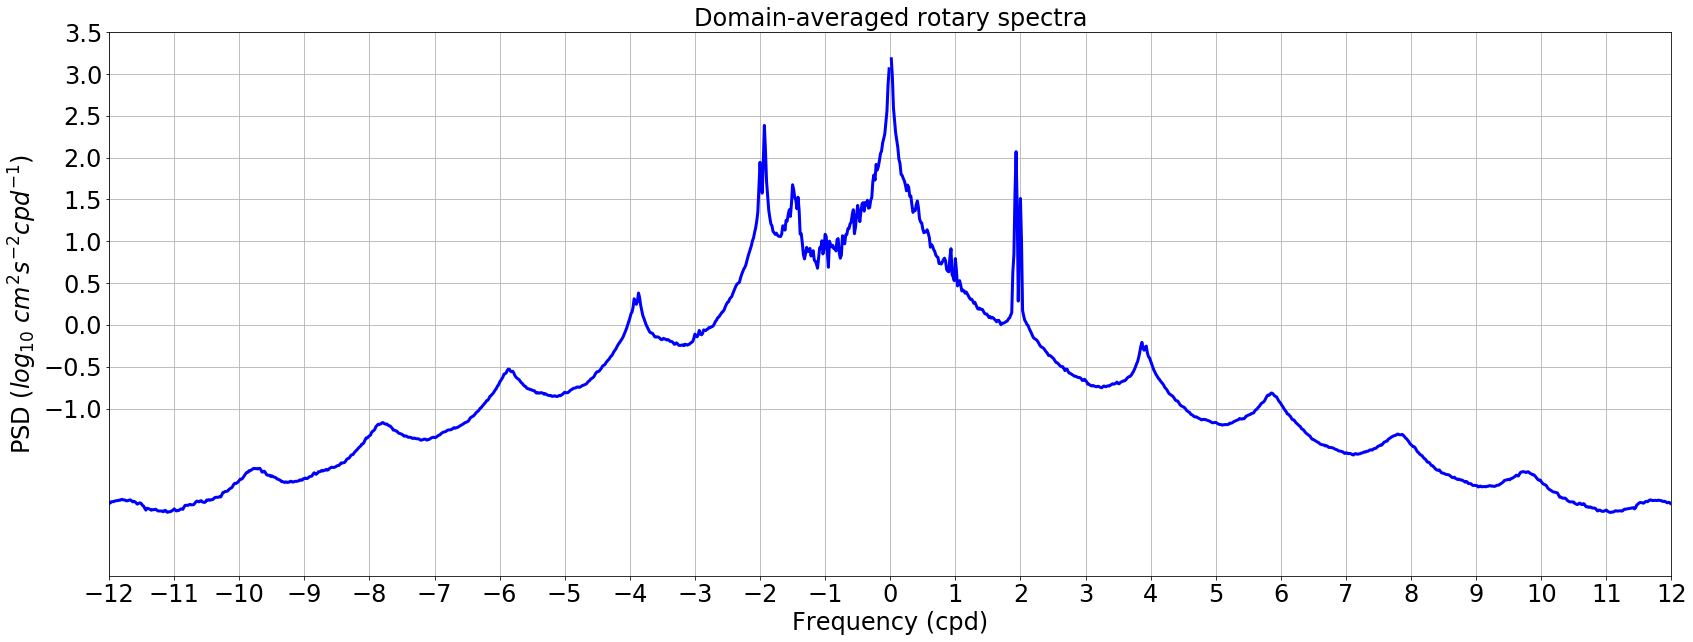

In [68]:
fig, ax = plt.subplots(figsize=(28,10))

ax = plt.subplot(1,1,1)
np.log10(E_uv_domain_mean).where(E_uv_domain_mean.freq_time>0.).plot(ax=ax, linewidth=3, color='blue')
np.log10(E_uv_domain_mean).where(E_uv_domain_mean.freq_time<0.).plot(ax=ax, linewidth=3, color='blue')
ax.grid()
ax.set_ylim([-3.,3.5])
ax.set_yticks([-1.,-0.5,0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5])
ax.set_xlim([-12.,12.])
ax.set_xticks([-12.,-11.,-10.,-9.,-8.,-7.,-6.,-5.,-4.,-3.,-2.,-1., 0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.set_ylabel('PSD ($log_{10}\ cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('Domain-averaged rotary spectra',fontsize=24)

# Surface

In [29]:
time_chunk = 1440

ds_U = xr.open_zarr(out_dir_zarr+'U_total.zarr')
ds_V = xr.open_zarr(out_dir_zarr+'V_total.zarr')

ds = xr.merge([ds_U['U'].isel(depth=0), ds_V['V'].isel(depth=0)])
time = np.arange(9415)*3600
ds = ds.assign_coords(time=time) 
chunks={'time': time_chunk, 'lat': 201, 'lon': 177} # time chunck: (2 months)
ds = ds.chunk(chunks) 
print(ds)

<xarray.Dataset>
Dimensions:  (lat: 201, lon: 177, time: 9415)
Coordinates:
    depth    float64 0.5
    dtime    (time) datetime64[ns] dask.array<shape=(9415,), chunksize=(1440,)>
  * lat      (lat) float32 47.404716 47.417923 47.43113 47.444332 47.45753 ...
  * lon      (lon) float32 -18.03125 -18.010416 -17.989584 -17.96875 ...
  * time     (time) int64 0 3600 7200 10800 14400 18000 21600 25200 28800 ...
Data variables:
    U        (time, lat, lon) float32 dask.array<shape=(9415, 201, 177), chunksize=(1440, 201, 177)>
    V        (time, lat, lon) float32 dask.array<shape=(9415, 201, 177), chunksize=(1440, 201, 177)>


In [38]:
uv_complex = (ds['U'] + 1j*ds['V']).isel(time=slice(0,8640))
uv_complex= uv_complex.rename('uv_complex')
uv_complex = uv_complex.to_dataset()
ds_subset = uv_complex.chunk({'time': 1440, 'lat':201, 'lon':177})
print(ds_subset)
print('\n data size: %.1f GB' %(ds_subset.nbytes / 1e9))

<xarray.Dataset>
Dimensions:     (lat: 201, lon: 177, time: 8640)
Coordinates:
    depth       float64 0.5
    dtime       (time) datetime64[ns] dask.array<shape=(8640,), chunksize=(1440,)>
  * lat         (lat) float32 47.404716 47.417923 47.43113 47.444332 ...
  * lon         (lon) float32 -18.03125 -18.010416 -17.989584 -17.96875 ...
  * time        (time) int64 0 3600 7200 10800 14400 18000 21600 25200 28800 ...
Data variables:
    uv_complex  (time, lat, lon) complex64 dask.array<shape=(8640, 201, 177), chunksize=(1440, 201, 177)>

 data size: 2.5 GB


In [40]:
ds_subset = (ds_subset.stack(point=['lat','lon']).chunk({'time': 1440, 'point': 100}))
print(ds_subset)
print('\n data size: %.1f GB' %(ds_subset.nbytes / 1e9))

<xarray.Dataset>
Dimensions:     (point: 35577, time: 8640)
Coordinates:
    depth       float64 0.5
    dtime       (time) datetime64[ns] dask.array<shape=(8640,), chunksize=(1440,)>
  * time        (time) int64 0 3600 7200 10800 14400 18000 21600 25200 28800 ...
  * point       (point) MultiIndex
  - lat         (point) float64 47.4 47.4 47.4 47.4 47.4 47.4 47.4 47.4 47.4 ...
  - lon         (point) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 ...
Data variables:
    uv_complex  (time, point) complex64 dask.array<shape=(8640, 35577), chunksize=(1440, 100)>

 data size: 2.5 GB


In [59]:
# constant detrending, windowig
uv_fft_complex = xrft.dft(ds_subset.uv_complex.fillna(0.), dim=['time'], shift=False, detrend='constant', window=True, chunks_to_segments=True)
E_uv_segments = (uv_fft_complex*uv_fft_complex.conj()).where(uv_fft_complex!=0., drop=False)/1440*3600
E_uv = E_uv_segments.mean(dim=['time_segment']) 
E_uv = E_uv.assign_coords(freq_cpd=E_uv.freq_time * 86400.) 
E_uv = np.real(E_uv).rename('E_uv')
print(E_uv)

<xarray.DataArray 'E_uv' (freq_time: 1440, point: 35577)>
dask.array<shape=(1440, 35577), dtype=float64, chunksize=(1440, 100)>
Coordinates:
  * freq_time          (freq_time) float64 0.0 1.929e-07 3.858e-07 5.787e-07 ...
  * point              (point) object (47.40471649169922, -18.03125) ...
    freq_time_spacing  float64 1.929e-07
    freq_cpd           (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...


In [60]:
E_uv.load()

<xarray.DataArray 'E_uv' (freq_time: 1440, point: 35577)>
array([[ 2334.462597,  2302.227618,  2324.50269 , ...,  1660.666847,
         1584.086303,  1515.571369],
       [ 8650.315895,  8775.862322,  9037.69136 , ...,  8016.072786,
         8216.465546,  8364.640113],
       [ 8459.920716,  9259.623412, 10051.223948, ...,  4679.454484,
         4631.501994,  4635.271646],
       ...,
       [ 2755.053072,  2478.410487,  2127.645072, ...,  2602.867519,
         2977.089601,  3341.960543],
       [ 6581.258201,  5927.810019,  5294.209843, ...,  2097.831673,
         2239.34482 ,  2333.656586],
       [ 7205.616057,  6902.026209,  6651.212163, ...,  2439.882755,
         2563.233947,  2627.823869]])
Coordinates:
  * freq_time          (freq_time) float64 0.0 1.929e-07 3.858e-07 5.787e-07 ...
  * point              (point) object (47.40471649169922, -18.03125) ...
    freq_time_spacing  float64 1.929e-07
    freq_cpd           (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...

In [49]:
E_uv_zonmean = (E_uv.groupby_bins(ds_subset['lat'], np.arange(46.5, 50, 0.5), labels=np.arange(47, 50, 0.5)).mean(dim=['point']))
E_llc_constant_window = E_uv_zonmean.chunk({'freq_time': 1440, 'lat_bins': 1})
E_llc_constant_window = np.real(E_llc_constant_window).rename('E_llc_constant_window')
print(E_llc_constant_window)
file_E = out_dir_zarr+'E_llc_OSMOSIS_0m.zarr'
%time E_llc_constant_window.to_dataset().to_zarr(file_E, mode='w')

<xarray.DataArray 'E_llc_constant_window' (freq_time: 1440, lat_bins: 6)>
dask.array<shape=(1440, 6), dtype=float64, chunksize=(1440, 1)>
Coordinates:
  * lat_bins           (lat_bins) float64 47.0 47.5 48.0 48.5 49.0 49.5
  * freq_time          (freq_time) float64 0.0 1.929e-07 3.858e-07 5.787e-07 ...
    freq_time_spacing  float64 1.929e-07
    freq_cpd           (freq_time) float64 dask.array<shape=(1440,), chunksize=(1440,)>
CPU times: user 1min 41s, sys: 3.48 s, total: 1min 44s
Wall time: 2min 13s


In [6]:
ds = xr.open_zarr(out_dir_zarr+'E_llc_OSMOSIS_0m.zarr')#.chunk({'freq_time': 1440, 'lat_bins': 1}) 
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

ValueError: group not found at path ''

Text(0.5,1,'LLC')

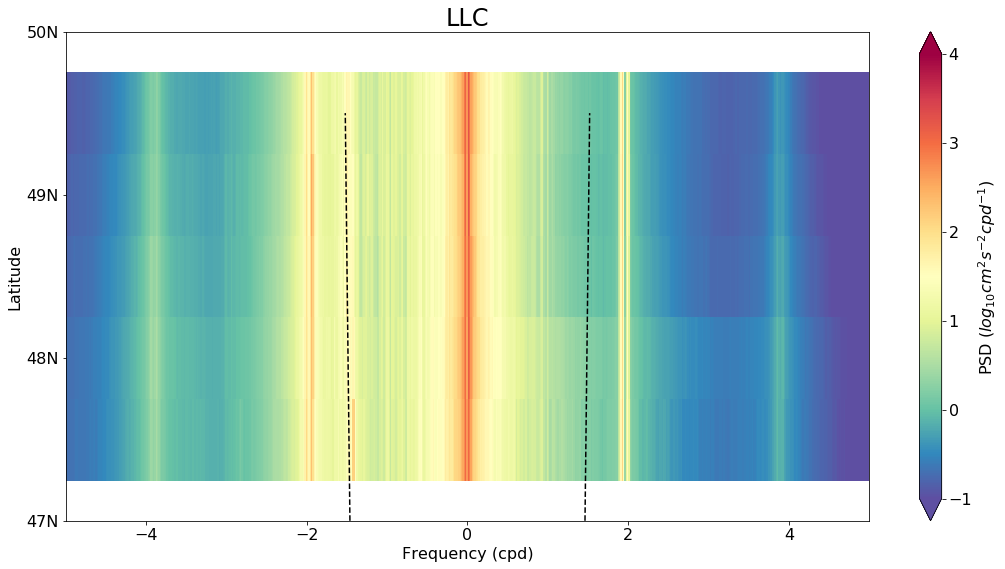

In [55]:

E_llc_constant_window = ds.E_llc_constant_window

plt.figure(figsize=(18,9))

## Drifter
ax = plt.subplot(1,1,1)
cax = np.log10(E_llc_constant_window.sortby('freq_time')/8.64).plot.pcolormesh(ax=ax, vmin=-1, vmax=4., x='freq_cpd', y='lat_bins', cmap = 'Spectral_r', add_colorbar = False)
# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=16)
cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=16) 
# x,y ticks
#ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(47., 50.)
ax.set_yticks([47., 48., 49.,50.])
ax.set_yticklabels(['47N','48N','49N','50N'])
ax.set_ylabel('Latitude',fontsize=16)
ax.set_xlabel('Frequency (cpd)',fontsize=16)
ax.tick_params(labelsize=16)
# add coriolis frequency
f_llc = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E_llc_constant_window.lat_bins))
ax.plot(f_llc*86400./2./np.pi,f_llc.lat_bins,'k--')
ax.plot(-f_llc*86400./2./np.pi,f_llc.lat_bins,'k--')
ax.set_title('LLC',fontsize=24)

In [69]:
# The domain is in the Northern Hemisphere, a direct average over latitude is fine to estimte domain-averaged rotary spectra.
E_uv_domain_mean = E_uv.mean(dim=('point'))/8.64
E_uv_domain_mean = np.real(E_uv_domain_mean).rename('E_uv_domain_mean')
#E_uv_domain_mean = E_uv_domain_mean.assign_coords(freq_time=E_uv_domain_mean.freq_time * 86400.) 

print(E_uv_domain_mean)
file_E = out_dir_zarr+'E_drifter_uv_domain_average_OSMOSIS_0m.zarr'
%time E_uv_domain_mean.to_dataset().to_zarr(file_E, mode='w')  

<xarray.DataArray 'E_uv_domain_mean' (freq_time: 1440)>
array([ 447.471252, 1521.868603,  906.677428, ...,  362.16403 ,  744.597839,
       1154.264367])
Coordinates:
  * freq_time          (freq_time) float64 0.0 1.929e-07 3.858e-07 5.787e-07 ...
    freq_time_spacing  float64 1.929e-07
    freq_cpd           (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...
CPU times: user 12 ms, sys: 8 ms, total: 20 ms
Wall time: 50.8 ms


Text(0.5,1,'Domain-averaged rotary spectra')

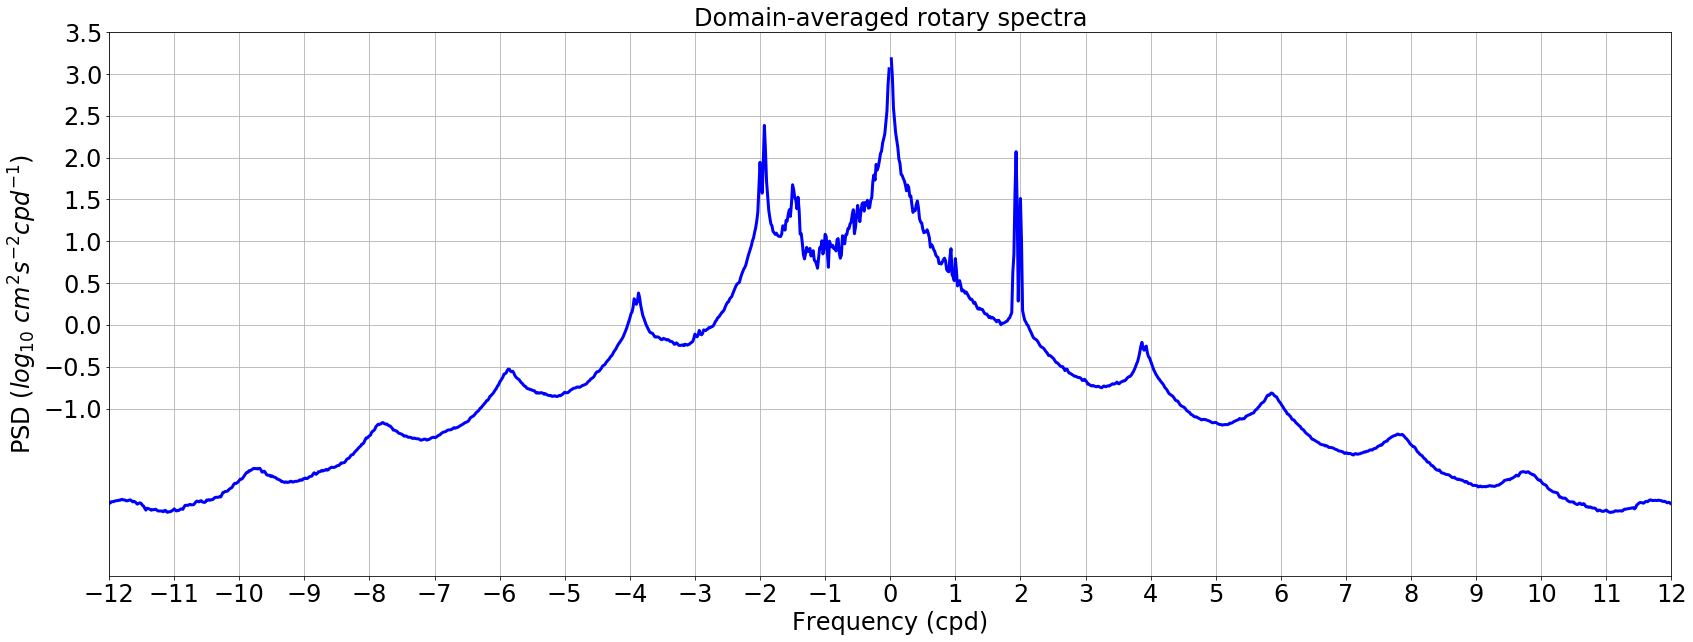

In [68]:
fig, ax = plt.subplots(figsize=(28,10))

ax = plt.subplot(1,1,1)
np.log10(E_uv_domain_mean).where(E_uv_domain_mean.freq_time>0.).plot(ax=ax, linewidth=3, color='blue')
np.log10(E_uv_domain_mean).where(E_uv_domain_mean.freq_time<0.).plot(ax=ax, linewidth=3, color='blue')
ax.grid()
ax.set_ylim([-3.,3.5])
ax.set_yticks([-1.,-0.5,0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5])
ax.set_xlim([-12.,12.])
ax.set_xticks([-12.,-11.,-10.,-9.,-8.,-7.,-6.,-5.,-4.,-3.,-2.,-1., 0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.set_ylabel('PSD ($log_{10}\ cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('Domain-averaged rotary spectra',fontsize=24)

# 15 m

In [71]:
time_chunk = 1440

ds_U = xr.open_zarr(out_dir_zarr+'U_total.zarr')
ds_V = xr.open_zarr(out_dir_zarr+'V_total.zarr')

ds = xr.merge([ds_U['U'].isel(depth=8), ds_V['V'].isel(depth=8)])
time = np.arange(9415)*3600
ds = ds.assign_coords(time=time) 
chunks={'time': time_chunk, 'lat': 201, 'lon': 177} # time chunck: (2 months)
ds = ds.chunk(chunks) 
print(ds)

<xarray.Dataset>
Dimensions:  (lat: 201, lon: 177, time: 9415)
Coordinates:
    depth    float64 14.68
    dtime    (time) datetime64[ns] dask.array<shape=(9415,), chunksize=(1440,)>
  * lat      (lat) float32 47.404716 47.417923 47.43113 47.444332 47.45753 ...
  * lon      (lon) float32 -18.03125 -18.010416 -17.989584 -17.96875 ...
  * time     (time) int64 0 3600 7200 10800 14400 18000 21600 25200 28800 ...
Data variables:
    U        (time, lat, lon) float32 dask.array<shape=(9415, 201, 177), chunksize=(1440, 201, 177)>
    V        (time, lat, lon) float32 dask.array<shape=(9415, 201, 177), chunksize=(1440, 201, 177)>


In [72]:
uv_complex = (ds['U'] + 1j*ds['V']).isel(time=slice(0,8640))
uv_complex= uv_complex.rename('uv_complex')
uv_complex = uv_complex.to_dataset()
ds_subset = uv_complex.chunk({'time': 1440, 'lat':201, 'lon':177})
print(ds_subset)
print('\n data size: %.1f GB' %(ds_subset.nbytes / 1e9))

<xarray.Dataset>
Dimensions:     (lat: 201, lon: 177, time: 8640)
Coordinates:
    depth       float64 14.68
    dtime       (time) datetime64[ns] dask.array<shape=(8640,), chunksize=(1440,)>
  * lat         (lat) float32 47.404716 47.417923 47.43113 47.444332 ...
  * lon         (lon) float32 -18.03125 -18.010416 -17.989584 -17.96875 ...
  * time        (time) int64 0 3600 7200 10800 14400 18000 21600 25200 28800 ...
Data variables:
    uv_complex  (time, lat, lon) complex64 dask.array<shape=(8640, 201, 177), chunksize=(1440, 201, 177)>

 data size: 2.5 GB


In [73]:
ds_subset = (ds_subset.stack(point=['lat','lon']).chunk({'time': 1440, 'point': 100}))
print(ds_subset)
print('\n data size: %.1f GB' %(ds_subset.nbytes / 1e9))

<xarray.Dataset>
Dimensions:     (point: 35577, time: 8640)
Coordinates:
    depth       float64 14.68
    dtime       (time) datetime64[ns] dask.array<shape=(8640,), chunksize=(1440,)>
  * time        (time) int64 0 3600 7200 10800 14400 18000 21600 25200 28800 ...
  * point       (point) MultiIndex
  - lat         (point) float64 47.4 47.4 47.4 47.4 47.4 47.4 47.4 47.4 47.4 ...
  - lon         (point) float64 -18.03 -18.01 -17.99 -17.97 -17.95 -17.93 ...
Data variables:
    uv_complex  (time, point) complex64 dask.array<shape=(8640, 35577), chunksize=(1440, 100)>

 data size: 2.5 GB


In [74]:
# constant detrending, windowig
uv_fft_complex = xrft.dft(ds_subset.uv_complex.fillna(0.), dim=['time'], shift=False, detrend='constant', window=True, chunks_to_segments=True)
E_uv_segments = (uv_fft_complex*uv_fft_complex.conj()).where(uv_fft_complex!=0., drop=False)/1440*3600
E_uv = E_uv_segments.mean(dim=['time_segment']) 
E_uv = E_uv.assign_coords(freq_cpd=E_uv.freq_time * 86400.) 
E_uv = np.real(E_uv).rename('E_uv')
print(E_uv)

<xarray.DataArray 'E_uv' (freq_time: 1440, point: 35577)>
dask.array<shape=(1440, 35577), dtype=float64, chunksize=(1440, 100)>
Coordinates:
  * freq_time          (freq_time) float64 0.0 1.929e-07 3.858e-07 5.787e-07 ...
  * point              (point) object (47.40471649169922, -18.03125) ...
    freq_time_spacing  float64 1.929e-07
    freq_cpd           (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...


In [75]:
E_uv.load()

<xarray.DataArray 'E_uv' (freq_time: 1440, point: 35577)>
array([[ 2149.471424,  2164.039872,  2200.038409, ...,  2183.184852,
         2143.899915,  2091.494095],
       [ 7231.878171,  7548.53508 ,  7919.179888, ...,  7697.433791,
         7861.819534,  7962.030914],
       [ 9923.743051, 10942.934169, 11955.242068, ...,  3480.0667  ,
         3600.731076,  3756.426813],
       ...,
       [ 2434.935406,  2215.642103,  1900.567831, ...,  1778.893308,
         2024.689436,  2291.235834],
       [ 7294.429991,  6576.051283,  5862.40918 , ...,  1678.35392 ,
         1849.804228,  2019.234171],
       [ 7296.488827,  6838.535125,  6433.755938, ...,  1987.542498,
         2094.72924 ,  2176.647865]])
Coordinates:
  * freq_time          (freq_time) float64 0.0 1.929e-07 3.858e-07 5.787e-07 ...
  * point              (point) object (47.40471649169922, -18.03125) ...
    freq_time_spacing  float64 1.929e-07
    freq_cpd           (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...

In [77]:
# The domain is in the Northern Hemisphere, a direct average over latitude is fine to estimte domain-averaged rotary spectra.
E_uv_domain_mean = E_uv.mean(dim=('point'))/8.64
E_uv_domain_mean = np.real(E_uv_domain_mean).rename('E_uv_domain_mean')
E_uv_domain_mean = E_uv_domain_mean.assign_coords(freq_time=E_uv_domain_mean.freq_time * 86400.) 

print(E_uv_domain_mean)
file_E = out_dir_zarr+'E_drifter_uv_domain_average_OSMOSIS_15m.zarr'
%time E_uv_domain_mean.to_dataset().to_zarr(file_E, mode='w')  

<xarray.DataArray 'E_uv_domain_mean' (freq_time: 1440)>
array([ 424.722218, 1442.247323,  813.991356, ...,  305.88258 ,  671.883267,
       1062.959858])
Coordinates:
  * freq_time          (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 1.929e-07
    freq_cpd           (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...
CPU times: user 12 ms, sys: 8 ms, total: 20 ms
Wall time: 55.5 ms


_______
# Figure

In [7]:
out_dir_zarr = '/home1/scratch/xyu/OSMOSIS_llc4320/zarr_file/'


In [8]:
ds_0 = xr.open_zarr(out_dir_zarr+'E_drifter_uv_domain_average_OSMOSIS_0m.zarr')#.chunk({'freq_time': 1440, 'lat': 201, 'lon':177}) 
ds_0 = ds_0.assign_coords(freq_time=ds_0.freq_time * 86400.) 

ds_15 = xr.open_zarr(out_dir_zarr+'E_drifter_uv_domain_average_OSMOSIS_15m.zarr')#.chunk({'freq_time': 1440, 'lat': 201, 'lon':177}) 
print(ds_0)

<xarray.Dataset>
Dimensions:            (freq_time: 1440)
Coordinates:
    freq_cpd           (freq_time) float64 dask.array<shape=(1440,), chunksize=(1440,)>
  * freq_time          (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 ...
Data variables:
    E_uv_domain_mean   (freq_time) float64 dask.array<shape=(1440,), chunksize=(1440,)>


In [14]:
ds_U = xr.open_zarr(out_dir_zarr+'U_total_rechunk.zarr')
lat = ds_U.lat_g
print(lat)

<xarray.DataArray 'lat_g' (lat_g: 201)>
array([47.39811 , 47.41132 , 47.424526, ..., 49.956215, 49.968845, 49.981472],
      dtype=float32)
Coordinates:
  * lat_g    (lat_g) float32 47.39811 47.41132 47.424526 47.43773 47.45093 ...


In [26]:
# tidal frequencies

f_llc = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(lat.lat_g))
f = -1*f_llc*86400./2./np.pi
print(f)

<xarray.DataArray 'lat_g' (lat_g: 201)>
array([-1.472149, -1.472462, -1.472773, ..., -1.531106, -1.53139 , -1.531673],
      dtype=float32)
Coordinates:
  * lat_g    (lat_g) float32 47.39811 47.41132 47.424526 47.43773 47.45093 ...


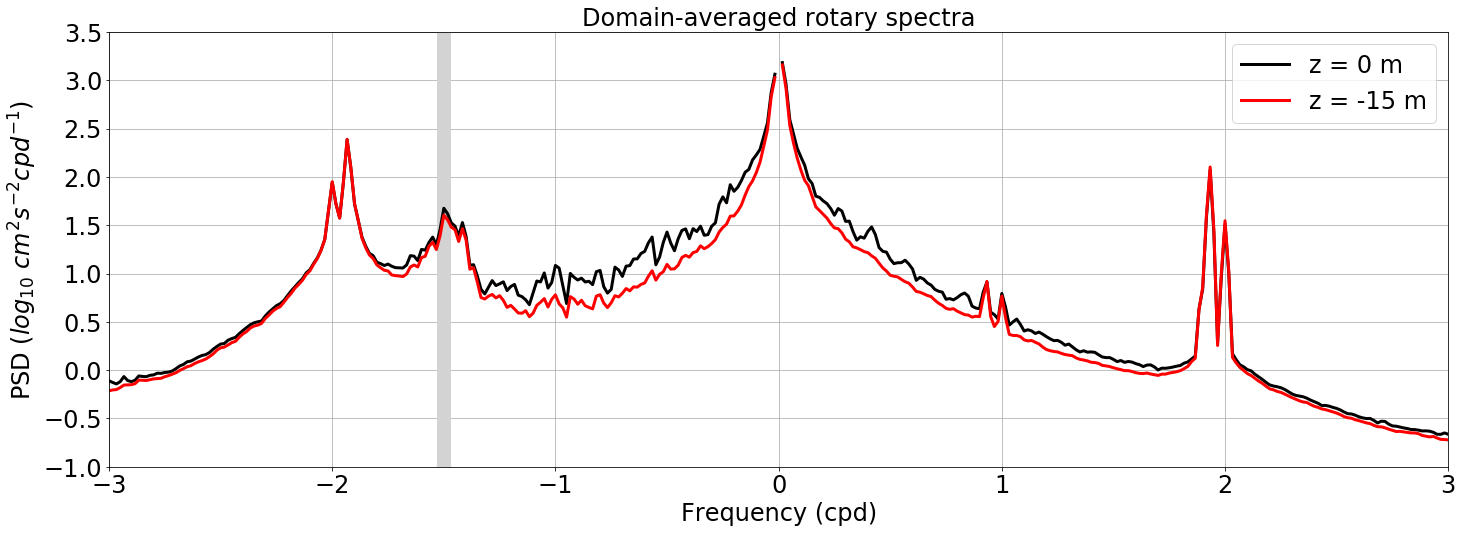

In [32]:
fig, ax = plt.subplots(figsize=(24,8))

labels = ['z = 0 m','z = -15 m']
font_size = 24


ax = plt.subplot(1,1,1)
ax.plot([-1*f_llc*86400./2./np.pi,-1*f_llc*86400./2./np.pi],[-2,4], linewidth=1, color='lightgrey') 

np.log10(ds_0.E_uv_domain_mean).where(ds_0.freq_time>0.).plot(ax=ax, linewidth=3, color='black',label=labels[0])
np.log10(ds_0.E_uv_domain_mean).where(ds_0.freq_time<0.).plot(ax=ax, linewidth=3, color='black')
np.log10(ds_15.E_uv_domain_mean).where(ds_15.freq_time>0.).plot(ax=ax, linewidth=3, color='red',label=labels[1])
np.log10(ds_15.E_uv_domain_mean).where(ds_15.freq_time<0.).plot(ax=ax, linewidth=3, color='red')

ax.grid()
ax.set_ylim([-1,3.5])
ax.set_yticks([-1.,-0.5,0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5])
ax.set_xlim([-3.,3.])
ax.set_xticks([-3.,-2.,-1., 0., 1., 2., 3.])
ax.legend(); 
ax.legend(prop={'size': font_size})

ax.set_ylabel('PSD ($log_{10}\ cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('Domain-averaged rotary spectra',fontsize=24)

#ax.plot([-1*f_llc*86400./2./np.pi,-1*f_llc*86400./2./np.pi],[-2,4], linewidth=1, color='lightgrey') 


plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/OSMOSIS_rspectra_zoom_3.png')

Text(0.5,1,'Domain-averaged rotary spectra')

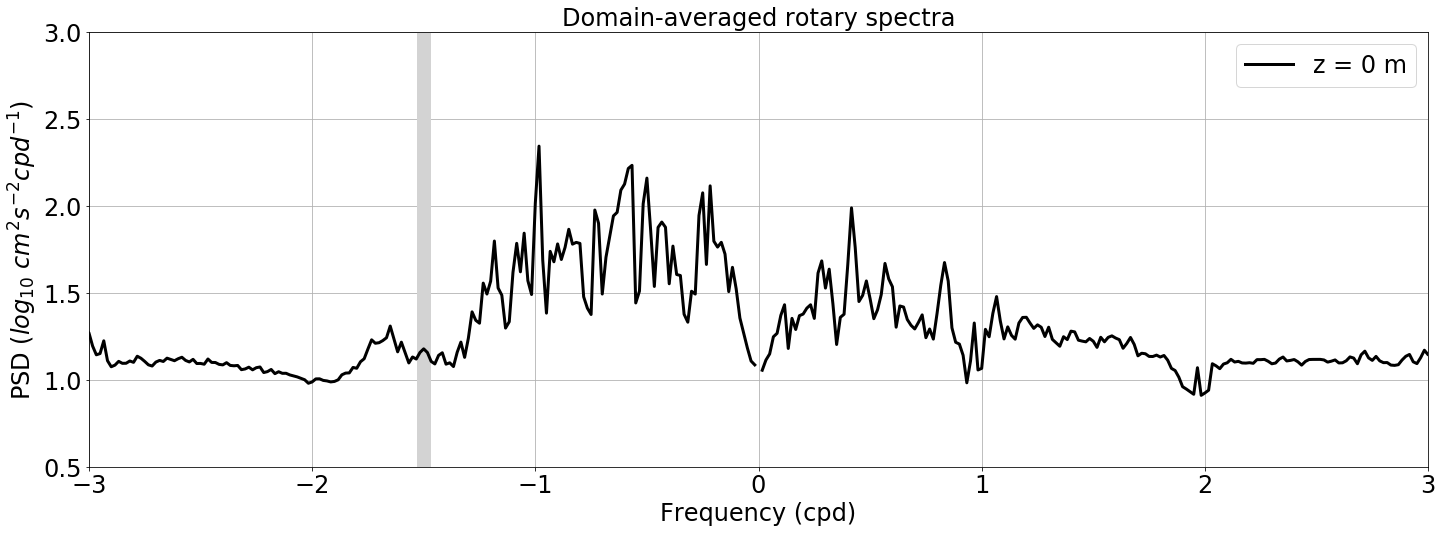

In [33]:
fig, ax = plt.subplots(figsize=(24,8))

labels = ['z = 0 m','z = -15 m']
font_size = 24


ax = plt.subplot(1,1,1)
ax.plot([-1*f_llc*86400./2./np.pi,-1*f_llc*86400./2./np.pi],[-2,4], linewidth=1, color='lightgrey') 

((ds_0.E_uv_domain_mean).where(ds_0.freq_time>0.)/(ds_15.E_uv_domain_mean).where(ds_15.freq_time>0.)).plot(ax=ax, linewidth=3, color='black',label=labels[0])
((ds_0.E_uv_domain_mean).where(ds_0.freq_time<0.)/(ds_15.E_uv_domain_mean).where(ds_15.freq_time<0.)).plot(ax=ax, linewidth=3, color='black')
#np.log10(ds_15.E_uv_domain_mean).where(ds_15.freq_time>0.).plot(ax=ax, linewidth=3, color='red',label=labels[1])
#np.log10(ds_15.E_uv_domain_mean).where(ds_15.freq_time<0.).plot(ax=ax, linewidth=3, color='red')

ax.grid()
ax.set_ylim([0.5,3.])
#ax.set_yticks([-1.,-0.5,0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5])
ax.set_xlim([-3.,3.])
ax.set_xticks([-3.,-2.,-1., 0., 1., 2., 3.])
ax.legend(); 
ax.legend(prop={'size': font_size})

ax.set_ylabel('PSD ($log_{10}\ cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('Domain-averaged rotary spectra',fontsize=24)

#ax.plot([-1*f_llc*86400./2./np.pi,-1*f_llc*86400./2./np.pi],[-2,4], linewidth=1, color='lightgrey') 


#plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/OSMOSIS_rspectra_zoom_3.png')

In [52]:
a = np.mean((np.log10(ds_0.E_uv_domain_mean)/np.log10(ds_15.E_uv_domain_mean)).where(abs(ds_0.freq_cpd)<0.5))
a.values

array(1.12215714)

In [40]:
ds_0.freq_time

<xarray.DataArray 'freq_cpd' (freq_time: 1440)>
dask.array<shape=(1440,), dtype=float64, chunksize=(1440,)>
Coordinates:
    freq_cpd           (freq_time) float64 dask.array<shape=(1440,), chunksize=(1440,)>
  * freq_time          (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 ...

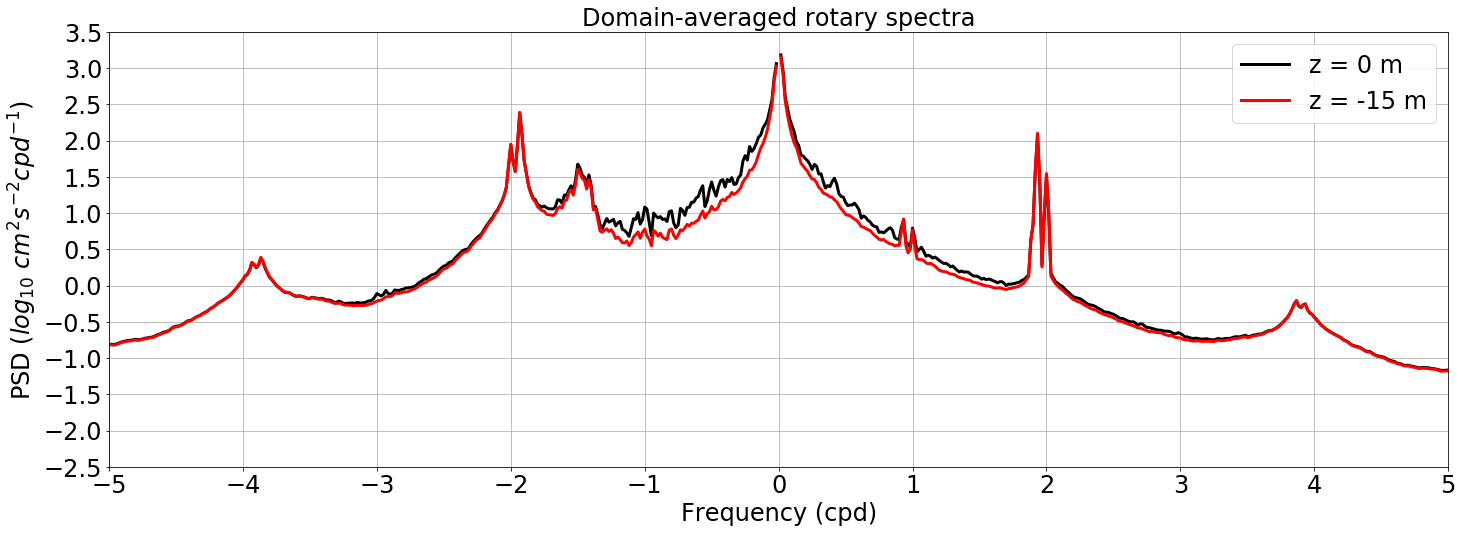

In [58]:
fig, ax = plt.subplots(figsize=(24,8))

labels = ['z = 0 m','z = -15 m']


ax = plt.subplot(1,1,1)
np.log10(ds_0.E_uv_domain_mean).where(ds_0.freq_time>0.).plot(ax=ax, linewidth=3, color='black',label=labels[0])
np.log10(ds_0.E_uv_domain_mean).where(ds_0.freq_time<0.).plot(ax=ax, linewidth=3, color='black')
np.log10(ds_15.E_uv_domain_mean).where(ds_15.freq_time>0.).plot(ax=ax, linewidth=3, color='red',label=labels[1])
np.log10(ds_15.E_uv_domain_mean).where(ds_15.freq_time<0.).plot(ax=ax, linewidth=3, color='red')

ax.grid()
ax.set_ylim([-2.5,3.5])
ax.set_yticks([-2.5,-2,-1.5,-1.,-0.5,0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5])
ax.set_xlim([-12.,12.])
ax.set_xticks([-12.,-11.,-10.,-9.,-8.,-7.,-6.,-5.,-4.,-3.,-2.,-1., 0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.set_xlim([-5.,5.])
ax.set_xticks([-5.,-4.,-3.,-2.,-1., 0., 1., 2., 3., 4., 5.])
ax.legend(); 
ax.legend(prop={'size': font_size})

ax.set_ylabel('PSD ($log_{10}\ cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('Domain-averaged rotary spectra',fontsize=24)

plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/OSMOSIS_rspectra_zoom.png')

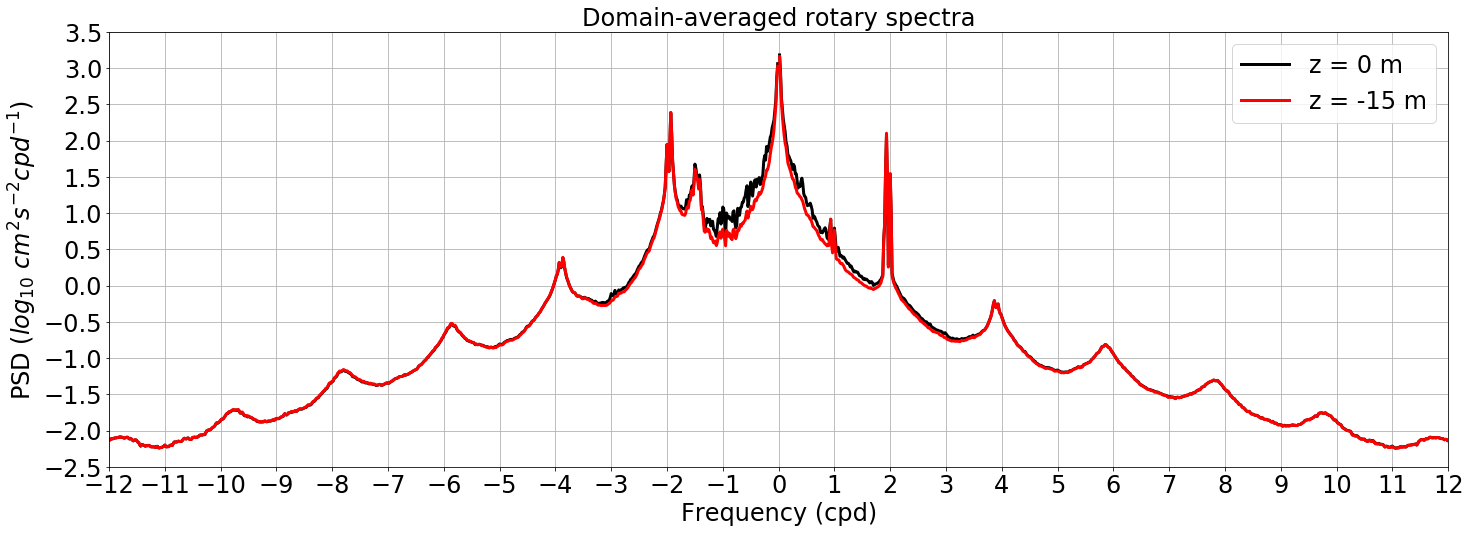

In [57]:
fig, ax = plt.subplots(figsize=(24,8))

labels = ['z = 0 m','z = -15 m']


ax = plt.subplot(1,1,1)
np.log10(ds_0.E_uv_domain_mean).where(ds_0.freq_time>0.).plot(ax=ax, linewidth=3, color='black',label=labels[0])
np.log10(ds_0.E_uv_domain_mean).where(ds_0.freq_time<0.).plot(ax=ax, linewidth=3, color='black')
np.log10(ds_15.E_uv_domain_mean).where(ds_15.freq_time>0.).plot(ax=ax, linewidth=3, color='red',label=labels[1])
np.log10(ds_15.E_uv_domain_mean).where(ds_15.freq_time<0.).plot(ax=ax, linewidth=3, color='red')

ax.grid()
ax.set_ylim([-2.5,3.5])
ax.set_yticks([-2.5,-2,-1.5,-1.,-0.5,0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5])
ax.set_xlim([-12.,12.])
ax.set_xticks([-12.,-11.,-10.,-9.,-8.,-7.,-6.,-5.,-4.,-3.,-2.,-1., 0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
#ax.set_xlim([-5.,5.])
#ax.set_xticks([-5.,-4.,-3.,-2.,-1., 0., 1., 2., 3., 4., 5.])
ax.legend(); 
ax.legend(prop={'size': font_size})

ax.set_ylabel('PSD ($log_{10}\ cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('Domain-averaged rotary spectra',fontsize=24)

plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/OSMOSIS_rspectra.png')


In [27]:

ds_U = xr.open_zarr(LLC_data_folder+'U_total.zarr')


print(ds_U)

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
    dtime    (time) datetime64[ns] dask.array<shape=(9415,), chunksize=(9415,)>
  * lat      (lat) float32 47.404716 47.417923 47.43113 47.444332 47.45753 ...
  * lon      (lon) float32 -18.03125 -18.010416 -17.989584 -17.96875 ...
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
Data variables:
    U        (time, depth, lat, lon) float32 dask.array<shape=(9415, 52, 201, 177), chunksize=(1, 52, 201, 177)>


In [38]:
font_size = 24
tem = ds_U['U'].isel(depth=0,time=0) 




fig, ax = plt.figure(figsize=(20,12))

ax = fig.add_subplot(111, projection=ccrs.PlateCarree())


cax = tem.plot.pcolormesh(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree(), cmap=cm.balance, vmin=-0.4, vmax=0.4)

cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=font_size)
#gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
#gl.xlabels_top = False
#gl.ylabels_right = False

#cbar = plt.colorbar(ax=ax, extend='both', orientation='vertical')
#cbar.ax.tick_params(labelsize=font_size)
#cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=font_size)
#ax.set_xlim([-15.6,-17.0]);
#ax.set_ylim([48,49.2]);
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)

TypeError: 'Figure' object is not iterable

<Figure size 1440x864 with 0 Axes>

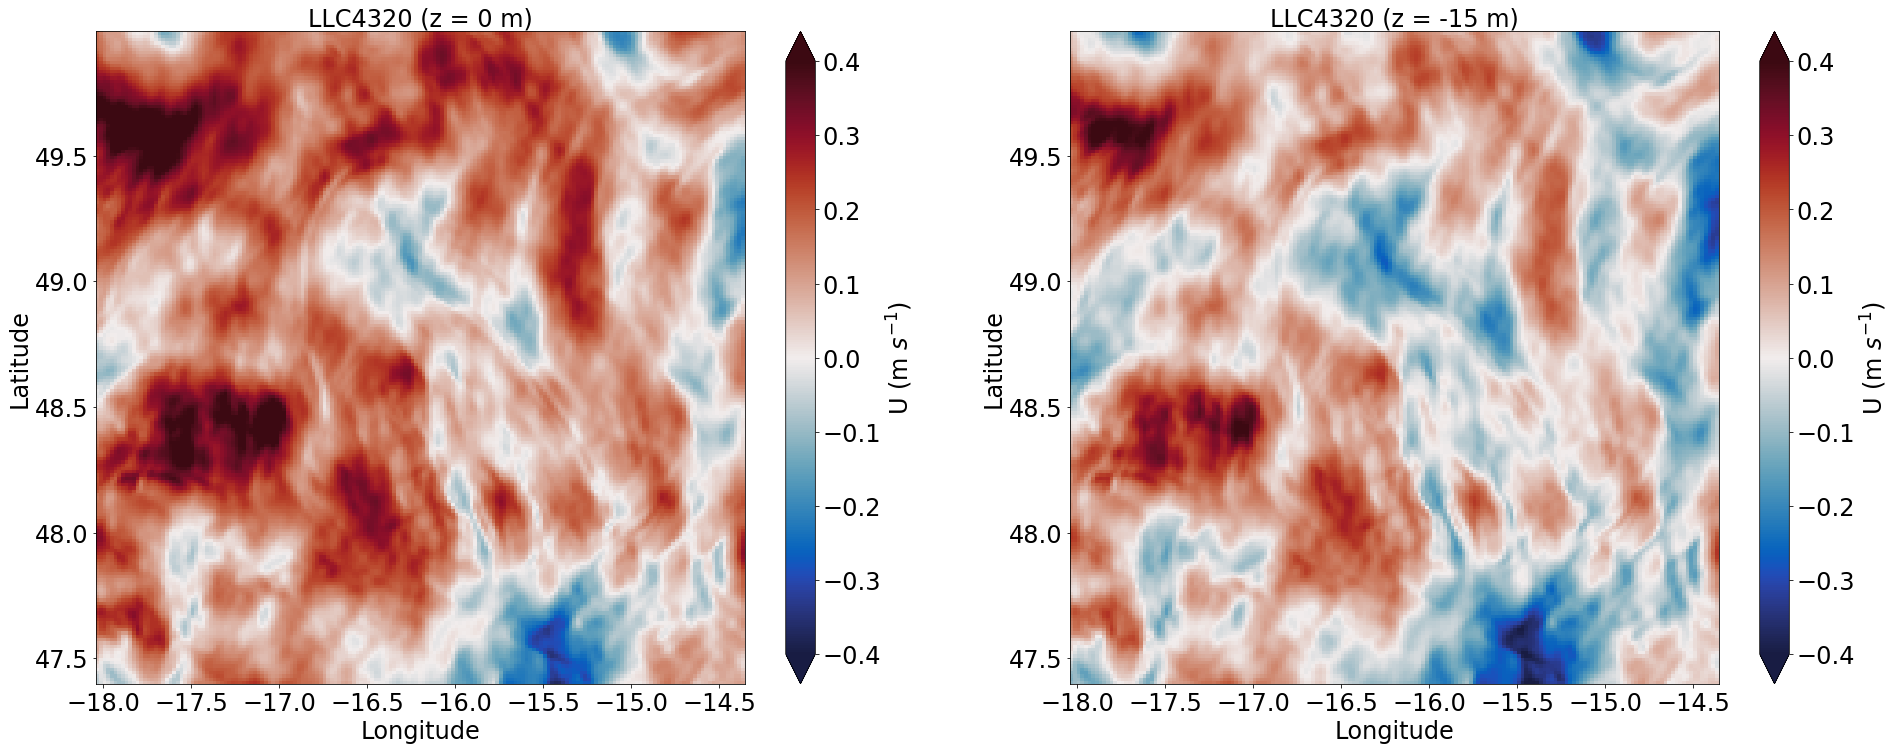

In [53]:
font_size = 24

time = 10

ds_U_0m = ds_U['U'].isel(depth=0,time=time) 
ds_U_15m = ds_U['U'].isel(depth=8,time=time) 


fig, ax = plt.subplots(figsize=(32,12))

# LLC4320
ax = plt.subplot(1,2,1)
cax = ds_U_0m.plot.pcolormesh(ax=ax, vmin=-0.4, vmax=.4, x='lon', y='lat', cmap = cm.balance, add_colorbar = False)
# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('U (m $s^{-1})$', fontsize=font_size)
# x,y ticks
#ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
#ax.set_xlim(-5., 5.)
#ax.set_ylim(-60., 60.)
#ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
#ax.set_yticklabels(['60S','40S','20S','0','20N','40N','60N'])
#ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Longitude',fontsize=font_size)
ax.tick_params(labelsize=24)
ax.set_title('LLC4320 (z = 0 m)',fontsize=font_size)

ax = plt.subplot(1,2,2)
cax = ds_U_15m.plot.pcolormesh(ax=ax, vmin=-0.4, vmax=.4, x='lon', y='lat', cmap = cm.balance, add_colorbar = False)
# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('U (m $s^{-1})$', fontsize=font_size)
# x,y ticks
#ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
#ax.set_xlim(-5., 5.)
#ax.set_ylim(-60., 60.)
#ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
#ax.set_yticklabels(['60S','40S','20S','0','20N','40N','60N'])
#ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Longitude',fontsize=font_size)
ax.tick_params(labelsize=24)
ax.set_title('LLC4320 (z = -15 m)',fontsize=font_size)

plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/OSMOSIS_U.png')


In [54]:
cluster.scheduler.close()

<Future finished result=None>